In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import (balanced_accuracy_score, ConfusionMatrixDisplay, 
                            recall_score, precision_score, f1_score)

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTEN

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# reading the youth model dataset 
youth_model = pd.read_csv("datasets/youth_model.csv")

youth_model.head()

,hmlsmorethan1Yr,dv_neglect,dv_physical,dv_physical_rel,dv_sexual_rel,subsabuse,drugabuse,SPA
0,1,1,1,1,0,0,0,4
1,1,0,0,0,1,0,0,4
2,1,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,4


# Normal KNN Model

In [3]:
# creating our X and y

features = ['dv_neglect', 'dv_physical', 'dv_physical_rel', 'dv_sexual_rel', 'subsabuse', 'drugabuse', 'SPA']

X = youth_model[features]
y = youth_model['hmlsmorethan1Yr']

In [4]:
# Train Test Split


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y)

In [5]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [6]:
# Instantiate KNN.
knn = KNeighborsClassifier()

#knn.fit(X_train, y_train)

In [7]:
cross_val_score(knn, X_train, y_train, cv = 5).mean()

0.6006734996121205

In [8]:
#let's manually tune this model
scores = []

for k in range(1, 51):
    for p in range(1, 4):
        for dist in ['uniform', 'distance']:
            knn = KNeighborsClassifier(n_neighbors=k, p = p, weights=dist)
            scores.append([k, p, dist, cross_val_score(knn, X_train, y_train, cv = 5).mean()])

In [10]:
scores

[[1, 1, 'uniform', 0.5919532664143492],
 [1, 1, 'distance', 0.5919532664143492],
 [1, 2, 'uniform', 0.5919520910223559],
 [1, 2, 'distance', 0.5919520910223559],
 [1, 3, 'uniform', 0.5904957803427442],
 [1, 3, 'distance', 0.5904957803427442],
 [2, 1, 'uniform', 0.6336726298220456],
 [2, 1, 'distance', 0.6331918944968147],
 [2, 2, 'uniform', 0.6327005806436447],
 [2, 2, 'distance', 0.6331907191048215],
 [2, 3, 'uniform', 0.6322151437504407],
 [2, 3, 'distance', 0.6327052822116176],
 [3, 1, 'uniform', 0.6031018594701332],
 [3, 1, 'distance', 0.6098968005829943],
 [3, 2, 'uniform', 0.6021309856837255],
 [3, 2, 'distance', 0.6089259267965866],
 [3, 3, 'uniform', 0.6016443733985284],
 [3, 3, 'distance', 0.6094101882977974],
 [4, 1, 'uniform', 0.6370706880744728],
 [4, 1, 'distance', 0.6351359928536168],
 [4, 2, 'uniform', 0.6360998142880651],
 [4, 2, 'distance', 0.6346493805684197],
 [4, 3, 'uniform', 0.6356155527868544],
 [4, 3, 'distance', 0.6351348174616235],
 [5, 1, 'uniform', 0.6011577

In [11]:
#p is Eucledian distance
pd.DataFrame(scores, columns=['k', 'p', 'weights', 'CV score']).sort_values('CV score',
                                                                           ascending=False)

,k,p,weights,CV score
276,47,1,uniform,0.656482
294,50,1,uniform,0.655508
246,42,1,uniform,0.655025
240,41,1,uniform,0.654541
264,45,1,uniform,0.653568
...,...,...,...,...
0,1,1,uniform,0.591953
3,1,2,distance,0.591952
2,1,2,uniform,0.591952
5,1,3,distance,0.590496


In [9]:
knn_final = KNeighborsClassifier(n_neighbors= 47, p = 1, weights='uniform')

In [10]:
knn_final.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=47, p=1)

In [11]:
# train score
knn_final.score(X_train, y_train)

0.6627850557981563

In [12]:
# test score
knn_final.score(X_test, y_test)

0.6569767441860465

The model shows signs of slight overfit with the train score is 1 percent higher than its test score. 

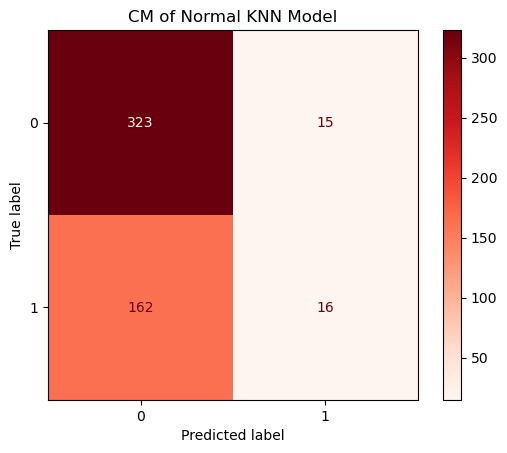

In [13]:
# Normal KNN Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_final, X_test, y_test, cmap = 'Reds')

# Get the axis of the plot
ax = plt.gca()

# Set the title
ax.set_title('CM of Normal KNN Model');

In [17]:
preds1 = knn_final.predict(X_test)
preds1[20:40]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [18]:
def evaluation(X_test, y_test, preds, model):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    
    b_acc = balanced_accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds, pos_label = 1)
    prec = precision_score(y_test, preds, pos_label = 1)
    f1 = f1_score(y_test, preds, pos_label = 1)

    print(f'balanced_accuracy: {b_acc}')
    print(f'recall: {recall}')
    print(f'precision: {prec}')
    print(f'f1 score: {f1}')

    return {
        'balanced_accuracy': b_acc,
        'recall': recall,
        'precision': prec,
        'f1_score': f1
    }

In [19]:
scores = []

balanced_accuracy: 0.5227544711122931
recall: 0.0898876404494382
precision: 0.5161290322580645
f1 score: 0.15311004784688995


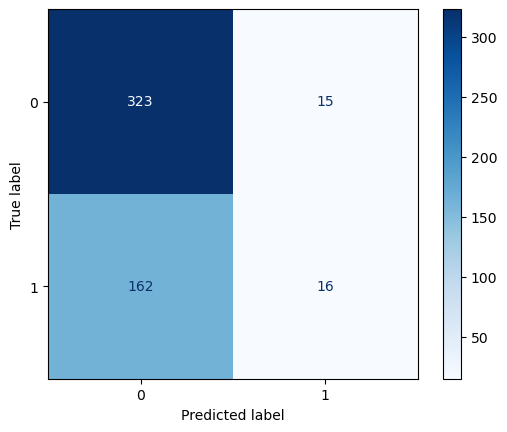

In [20]:
scores.append(evaluation(X_test, y_test, preds1, knn_final))


# Confusion Matrix of KNN Model
______

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 323 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 15 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 162 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 16 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 9% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 51% were actually true positives.
* For the F1 score, it heavily skews in identifying the negative class (youth who did not stay homeless more than 1 year).


# KNN Model with RandomOverSampler

In [21]:
pipe = make_pipeline(RandomOverSampler(random_state=42),
                     KNeighborsClassifier(n_neighbors= 47, p = 1, weights='uniform'))

In [22]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('randomoversampler', RandomOverSampler(random_state=42)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=47, p=1))])

balanced_accuracy: 0.5621800412206636
recall: 0.33146067415730335
precision: 0.4573643410852713
f1 score: 0.38436482084690554


{'balanced_accuracy': 0.5621800412206636,
 'recall': 0.33146067415730335,
 'precision': 0.4573643410852713,
 'f1_score': 0.38436482084690554}

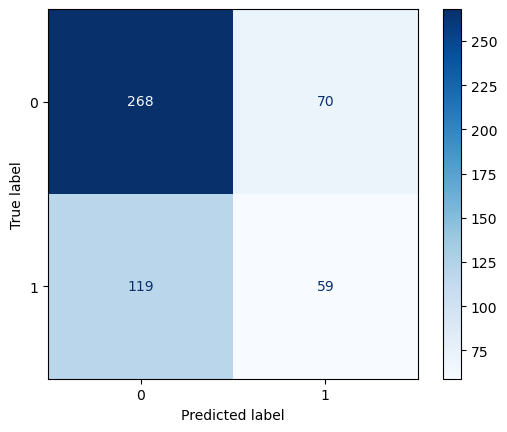

In [23]:
evaluation(X_test, y_test, pipe.predict(X_test), pipe)

# Confusion Matrix of KNN Model with RandomOverSampler
______

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 268 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 70 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 119 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 59 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 33% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 46% were actually true positives.
* For the F1 score, it heavily skews in identifying the negative class (youth who did not stay homeless more than 1 year).


In [24]:
gs = GridSearchCV(pipe,
                 param_grid=
                  {'randomoversampler__sampling_strategy' : [.25, .5, .75, 1.0]},
                 n_jobs=-1)

In [25]:
gs.fit(X_train, y_train)

C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\danie\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 322, in fit
    Xt, yt = self._fit(X, y,

GridSearchCV(estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=47,
                                                             p=1))]),
             n_jobs=-1,
             param_grid={'randomoversampler__sampling_strategy': [0.25, 0.5,
                                                                  0.75, 1.0]})

In [26]:
# train score
gs.score(X_train, y_train)

0.6462882096069869

In [27]:
# test score
gs.score(X_test, y_test)

0.6511627906976745

The model shows signs of underfitting since the test score is slightly higher than its train score.

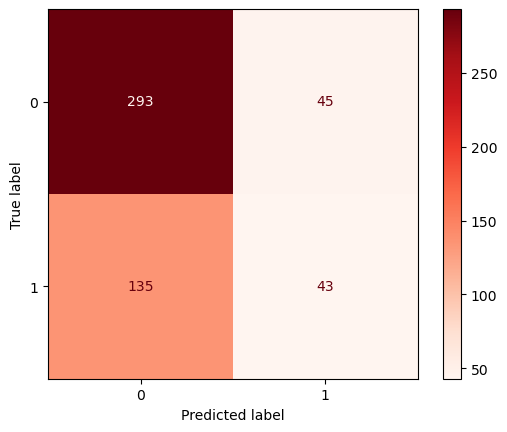

In [28]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap = 'Reds');

# Confusion Matrix of KNN Model with GridSearch and RandomOverSampler
______

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 293 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 45 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 135 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 43 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.


## Smarter Move: Grid search with balanced accuracy as your scoring metric

You can change the scoring metric for GridSearchCV. It will then pick the model that hasn't the best mean score on that metric.


In [29]:
gs2 = GridSearchCV(pipe,
                 param_grid=
                  {'randomoversampler__sampling_strategy' : [.25, .5, .75, 1.0]},
                 n_jobs=-1, scoring='balanced_accuracy')

In [30]:
gs2.fit(X_train, y_train)

C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\danie\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 322, in fit
    Xt, yt = self._fit(X, y,

GridSearchCV(estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=47,
                                                             p=1))]),
             n_jobs=-1,
             param_grid={'randomoversampler__sampling_strategy': [0.25, 0.5,
                                                                  0.75, 1.0]},
             scoring='balanced_accuracy')

In [31]:
# train score
gs2.score(X_train, y_train)

0.5612905411745082

In [32]:
# test score
gs2.score(X_test, y_test)

0.5621800412206636

The model's performance seems balanced with its train and test scores being similiar.

balanced_accuracy: 0.5621800412206636
recall: 0.33146067415730335
precision: 0.4573643410852713
f1 score: 0.38436482084690554


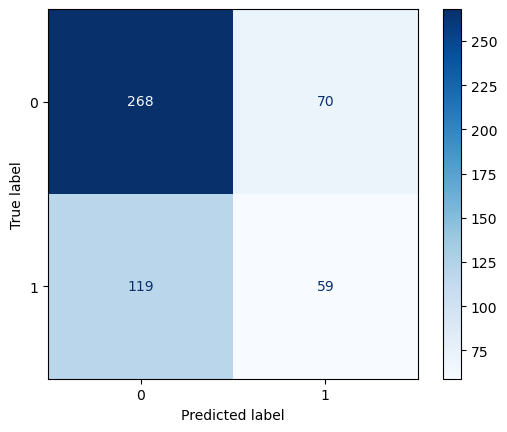

In [33]:
# making prediction
preds2 = gs2.predict(X_test)

# evaluating the model

scores.append(evaluation(X_test, y_test, preds2, gs2))

# Confusion Matrix of KNN Model with GridSearch, Balanced Accuracy, and RandomOverSampler
______

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 268 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 70 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 119 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 59 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 33% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 46% were actually true positives.
* For the F1 score, it heavily skews in identifying the negative class (youth who did not stay homeless more than 1 year).

In [34]:
pd.DataFrame(scores, index=['knn', 'RandomOverSampler'])

,balanced_accuracy,recall,precision,f1_score
knn,0.522754,0.089888,0.516129,0.153110
RandomOverSampler,0.562180,0.331461,0.457364,0.384365


# KNN Model with SMOTEN Method

In [35]:
pipe3 = make_pipeline(SMOTEN(random_state=42), KNeighborsClassifier(n_neighbors= 47, p = 1, weights='uniform'))

pipe3

Pipeline(steps=[('smoten', SMOTEN(random_state=42)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=47, p=1))])

In [36]:
gs3 = GridSearchCV(
    pipe3, 
    {'smoten__k_neighbors' : [3, 5, 7],
    }, 
    scoring='balanced_accuracy'
)

In [38]:
gs3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('smoten', SMOTEN(random_state=42)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=47,
                                                             p=1))]),
             param_grid={'smoten__k_neighbors': [3, 5, 7]},
             scoring='balanced_accuracy')

In [39]:
# train score
gs3.score(X_train, y_train)

0.5635215437703944

In [40]:
# test score
gs3.score(X_test, y_test)

0.5447277441659464

The model shows sign of overfitting with the train score higher than its test score.

balanced_accuracy: 0.5447277441659464
recall: 0.3202247191011236
precision: 0.4222222222222222
f1 score: 0.3642172523961661


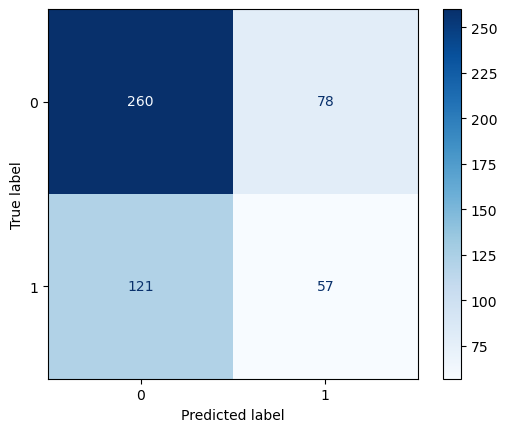

In [41]:
# create prediction
preds3 = gs3.predict(X_test)

# find out respective scores
scores.append(evaluation(X_test, y_test, preds3, gs3))

# Confusion Matrix of KNN Model with SMOTEN
______

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 260 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 78 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 121 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 57 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 32% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 42% were actually true positives.
* For the F1 score, it heavily skews in identifying the negative class (youth who did not stay homeless more than 1 year).

In [42]:
pd.DataFrame(scores, index=['knn', 'RamdomOverSampler', 'SMOTEN'])

,balanced_accuracy,recall,precision,f1_score
knn,0.522754,0.089888,0.516129,0.153110
RamdomOverSampler,0.562180,0.331461,0.457364,0.384365
SMOTEN,0.544728,0.320225,0.422222,0.364217


# ADASYN with KNN

In [43]:
pipe4 = make_pipeline(ADASYN(random_state=42),
                    KNeighborsClassifier(n_neighbors= 47, p = 1, weights='uniform'))

In [44]:
gs4 = GridSearchCV(
    pipe4, 
    {'adasyn__n_neighbors':[3,5,7],}, 
    scoring='balanced_accuracy',
    n_jobs=-1
)

In [45]:
gs4.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('adasyn', ADASYN(random_state=42)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=47,
                                                             p=1))]),
             n_jobs=-1, param_grid={'adasyn__n_neighbors': [3, 5, 7]},
             scoring='balanced_accuracy')

In [46]:
# train score
gs4.score(X_train, y_train)

0.5612801159287331

In [47]:
# test score
gs4.score(X_test, y_test)

0.5493152051060435

The model shows sign of overfitting with the train score higher than its test score. 

balanced_accuracy: 0.5493152051060435
recall: 0.3146067415730337
precision: 0.43410852713178294
f1 score: 0.36482084690553745


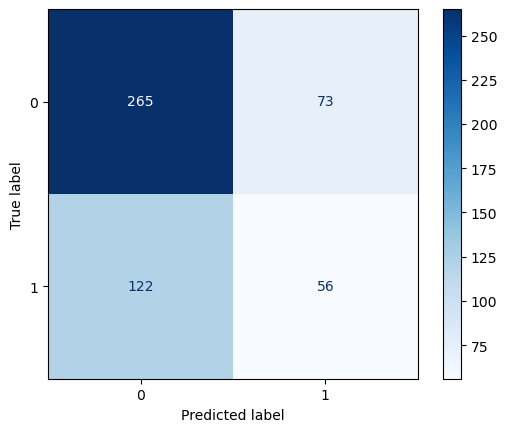

In [48]:
preds4 = gs4.predict(X_test)

scores.append(evaluation(X_test, y_test, preds4, gs4))

# Confusion Matrix of KNN Model with ADASYN
______

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 265 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 73 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 122 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 56 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 31% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 43% were actually true positives.
* For the F1 score, it heavily skews in identifying the negative class (youth who did not stay homeless more than 1 year).

In [49]:
pd.DataFrame(scores, index = ['knn', 'RandomOverSampler',
                             'SMOTEN', 'ADASYN'])

,balanced_accuracy,recall,precision,f1_score
knn,0.522754,0.089888,0.516129,0.153110
RandomOverSampler,0.562180,0.331461,0.457364,0.384365
SMOTEN,0.544728,0.320225,0.422222,0.364217
ADASYN,0.549315,0.314607,0.434109,0.364821


# KNN with Overweighing 
_____

since we don't have class_weight with KNN model, we will use weight as the main parameter to overweigh: 'distance': weight points by the inverse of their distance

In [50]:
knn5 = KNeighborsClassifier(n_neighbors= 47, p = 1, weights='distance')

knn5.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=47, p=1, weights='distance')

In [51]:
# train score
knn5.score(X_train, y_train)

0.710334788937409

In [52]:
# test score
knn5.score(X_test, y_test)

0.6608527131782945

The model shows signs of overfitting with the train score as higher than its test score. 

balanced_accuracy: 0.5390100392261152
recall: 0.14606741573033707
precision: 0.5306122448979592
f1 score: 0.22907488986784139


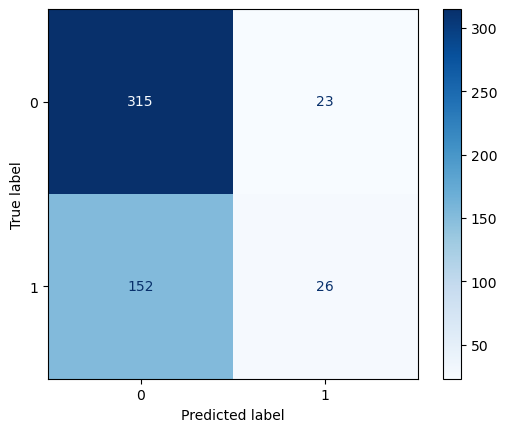

In [54]:
scores.append(evaluation(X_test, y_test, knn5.predict(X_test), knn5))

# Confusion Matrix of KNN Model with Overweighing
______

Youth who stayed homeless more than 1 year as our target / positive outcome:

* Our model correctly predicted 315 times that the youth did not stay homeless more than 1 year.
* Our model incorrectly predicted 23 times that youth stayed homeless more than 1 year when they actually did not.
* Our model incorrectly predicted 152 times that youth did not stay homeless more than 1 year when they actually did.
* Our model correctly predicted 26 times that youth stayed homeless more than 1 year.

The model shows more capability in identifying negative cases than positive cases.

* For balanced accuracy, the model's overall performance in terms of correctly classifying both positive and negative cases is moderate.
* For recall, the model correctly identified approximately 14% of the youth who stayed homeless more than 1 year.
* For out of all the cases predicted as youth staying homeless more than 1 year, approximately 53% were actually true positives.
* For the F1 score, it heavily skews in identifying the negative class (youth who did not stay homeless more than 1 year).

In [55]:
pd.DataFrame(scores, index=['knn', 'RandomOverSampler', 'SMOTEN', 'ADASYN', 'Weightedknn'])

,balanced_accuracy,recall,precision,f1_score
knn,0.522754,0.089888,0.516129,0.153110
RandomOverSampler,0.562180,0.331461,0.457364,0.384365
SMOTEN,0.544728,0.320225,0.422222,0.364217
ADASYN,0.549315,0.314607,0.434109,0.364821
Weightedknn,0.539010,0.146067,0.530612,0.229075
